In [1]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
from jaxmarl.environments.coin_game.make_train import make_train

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated CUDA installation found.
Version JAX was built against: 12030
Minimum supported: 12010
Installed version: 12000
The local installation version must be no lower than 12010.
--------------------------------------------------
Outdated cuBLAS installation found.
Version JAX was built against: 120304
Minimum supported: 120100
Installed version: 120002
The local installation version must be no lower than 120100.
--------------------------------------------------
Outdated cuSPARSE installation found.
Version JAX was built against: 12200
Minimum supported: 12100
Installed version: 12001
The local installation version must be no lower than 12100..(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Training

In [ ]:
# Hiperparámetros
NUM_ENVS = 4
NUM_INNER_STEPS = 50
NUM_EPOCHS = 500
NUM_AGENTS = 2
SHOW_EVERY_N_EPOCHS = 10
SAVE_EVERY_N_EPOCHS = 50
LR = 1e-4
PAYOFF_MATRIX = [[1, 2, -2], [1, 2, -2]]
GRID_SIZE = 4
REWARD_COEF = [[1, 0], [1, 0]]

In [ ]:
save_dir = '/data/samuel_lozano/coin_game/Prisioner_dilemma/'
training_type = 'AC Epoch'

config = {
    "NUM_ENVS": NUM_ENVS,
    "NUM_INNER_STEPS": NUM_INNER_STEPS,
    "NUM_EPOCHS": NUM_EPOCHS,
    "NUM_AGENTS": NUM_AGENTS,
    "SHOW_EVERY_N_EPOCHS": SHOW_EVERY_N_EPOCHS,
    "SAVE_EVERY_N_EPOCHS": SAVE_EVERY_N_EPOCHS,
    "LR": LR,
    "PAYOFF_MATRIX": PAYOFF_MATRIX,
    "GRID_SIZE": GRID_SIZE,
    "REWARD_COEF": REWARD_COEF,
    "SAVE_DIR": save_dir,
    "TRAINING_TYPE": training_type
}

params = make_train(config)

# Analysis

In [16]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Directorios base
base_dirs = {
    "Prisioner_dilemma": "/data/samuel_lozano/coin_game/Prisioner_dilemma",
    "No_dilemma": "/data/samuel_lozano/coin_game/No_dilemma"
}

In [13]:
all_dfs = []

# Patrón para capturar los coeficientes de recompensa
reward_pattern = re.compile(r"REWARD_COEF:\s*\[\[\s*([\d\.eE+-]+),\s*([\d\.eE+-]+)\],\s*\[\s*([\d\.eE+-]+),\s*([\d\.eE+-]+)\]\]")

In [14]:
for dilemma_name, base_dir in base_dirs.items():
    dilemma_flag = 1 if "Prisioner" in dilemma_name else 0
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        date_time_str = folder.replace("Training_", "")
        config_path = os.path.join(folder_path, "config.txt")
        csv_path = os.path.join(folder_path, "training_stats.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            continue

        with open(config_path, "r") as f:
            config_contents = f.read()
        match = reward_pattern.search(config_contents)
        if not match:
            continue

        alpha_1, beta_1, alpha_2, beta_2 = map(float, match.groups())
        df = pd.read_csv(csv_path)

        df.insert(0, "FECHA_HORA", date_time_str)
        df.insert(1, "dilemma", dilemma_flag)
        df.insert(2, "alpha_1", alpha_1)
        df.insert(3, "beta_1", beta_1)
        df.insert(4, "alpha_2", alpha_2)
        df.insert(5, "beta_2", beta_2)

        all_dfs.append(df)

In [15]:
# Concatenar todos los resultados
final_df = pd.concat(all_dfs, ignore_index=True)
output_path = "/data/samuel_lozano/coin_game/training_results.csv"
final_df.to_csv(output_path, index=False)

# Visualization

In [30]:
# Leer el CSV especificando los tipos de datos
dtype_dict = {
    "FECHA_HORA": str,
    "dilemma": int,
    "alpha_1": float,
    "beta_1": float,
    "alpha_2": float,
    "beta_2": float
}

# Cargar el CSV con conversión explícita al tipo numérico para el resto de columnas
df = pd.read_csv("/data/samuel_lozano/coin_game/training_results.csv", dtype=dtype_dict, low_memory=False)
for col in df.columns[6:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear una columna identificadora de combinación de coeficientes
df = df.sort_values(by=["alpha_1", "alpha_2"], ascending=[False, False])
df["attitude_key"] = df.apply(lambda row: f"{row['alpha_1']}_{row['beta_1']}_{row['alpha_2']}_{row['beta_2']}", axis=1)

In [31]:
# Filtrar todas las combinaciones únicas
unique_attitudes = df["attitude_key"].unique()

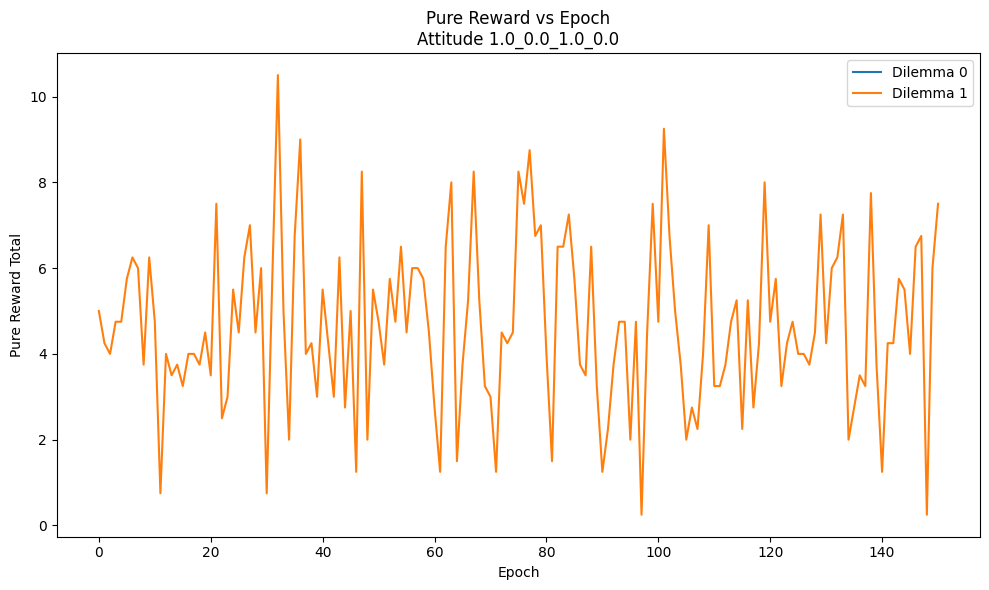

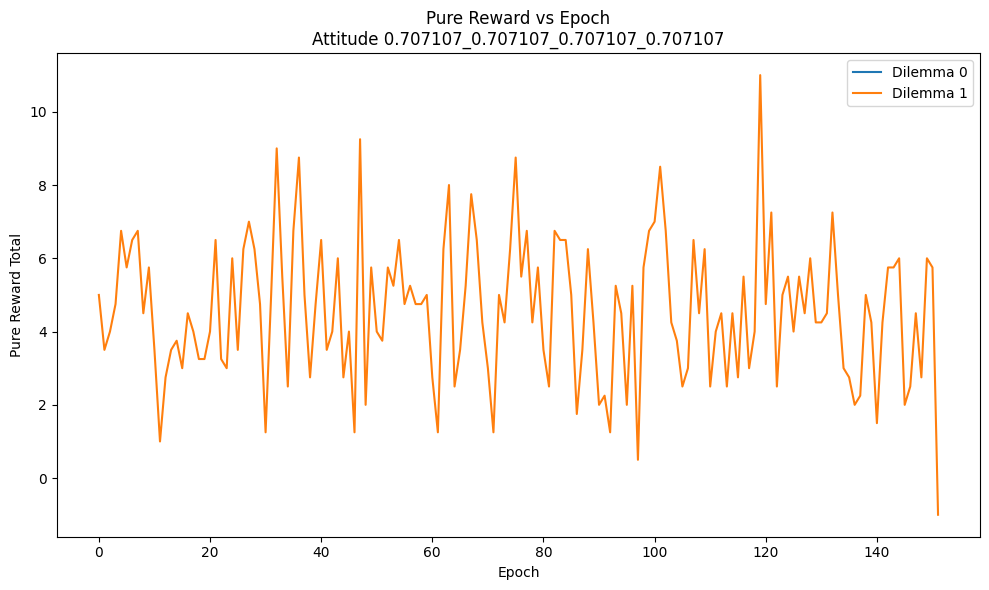

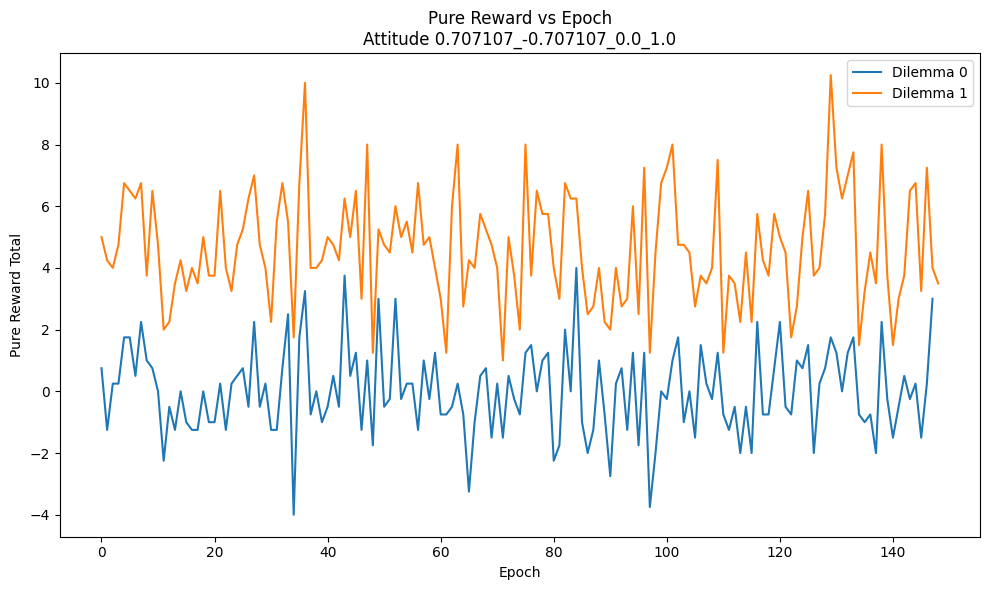

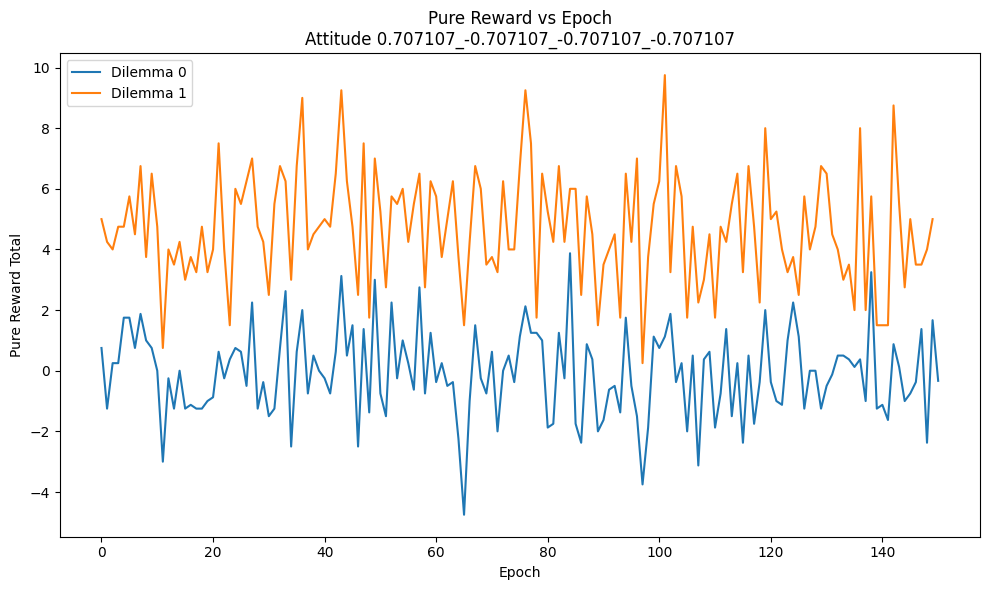

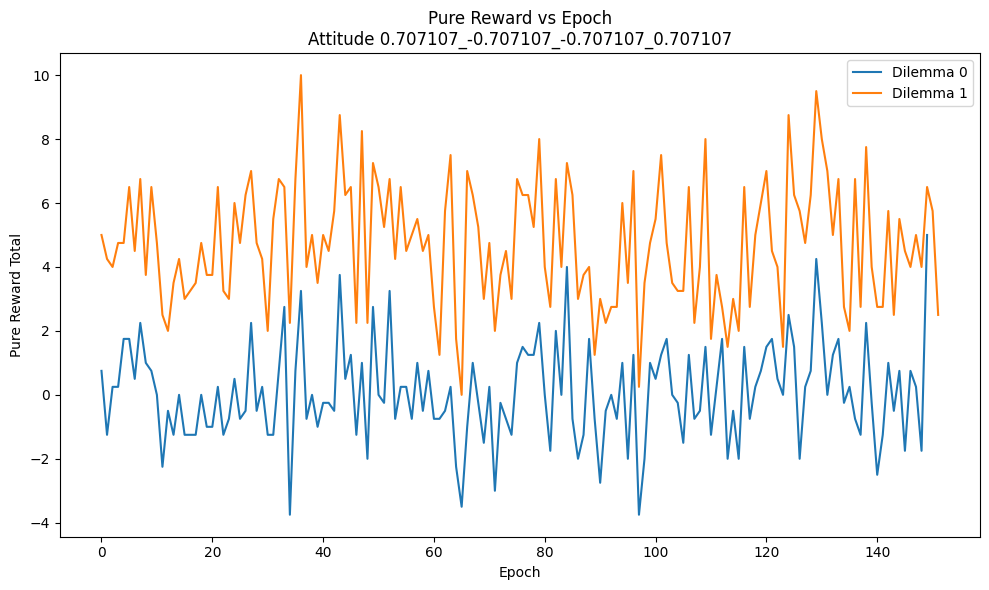

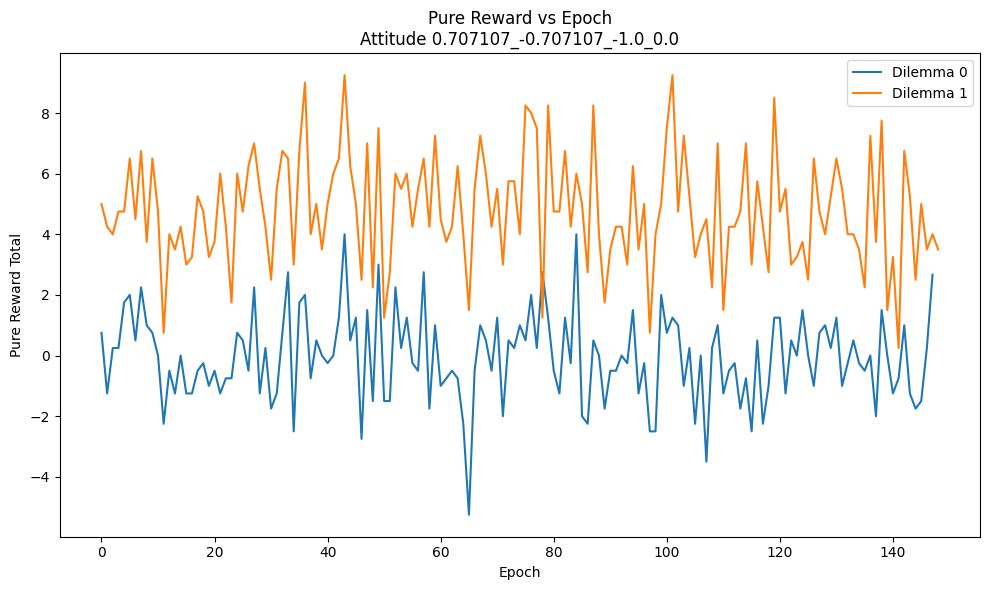

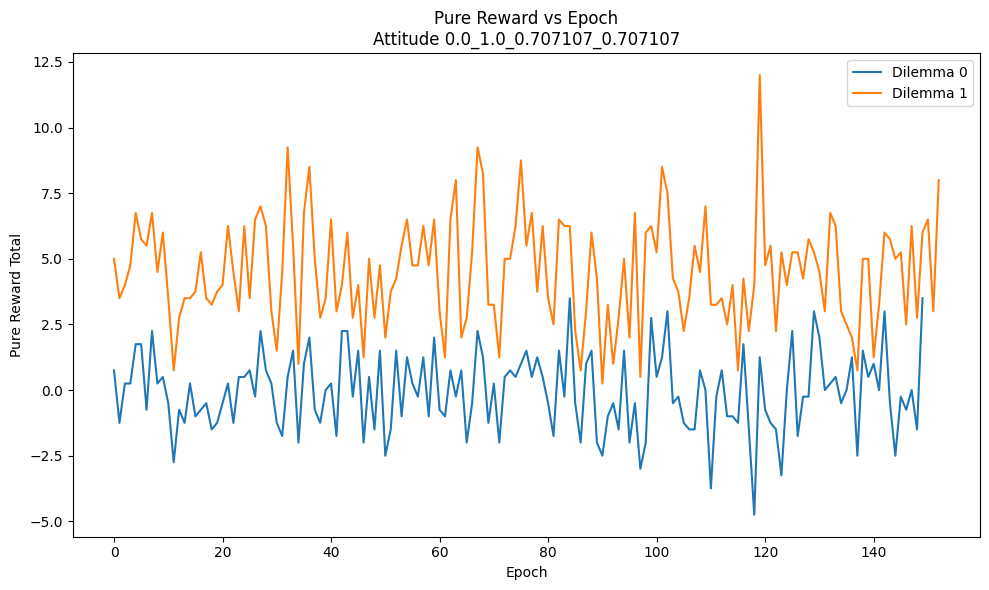

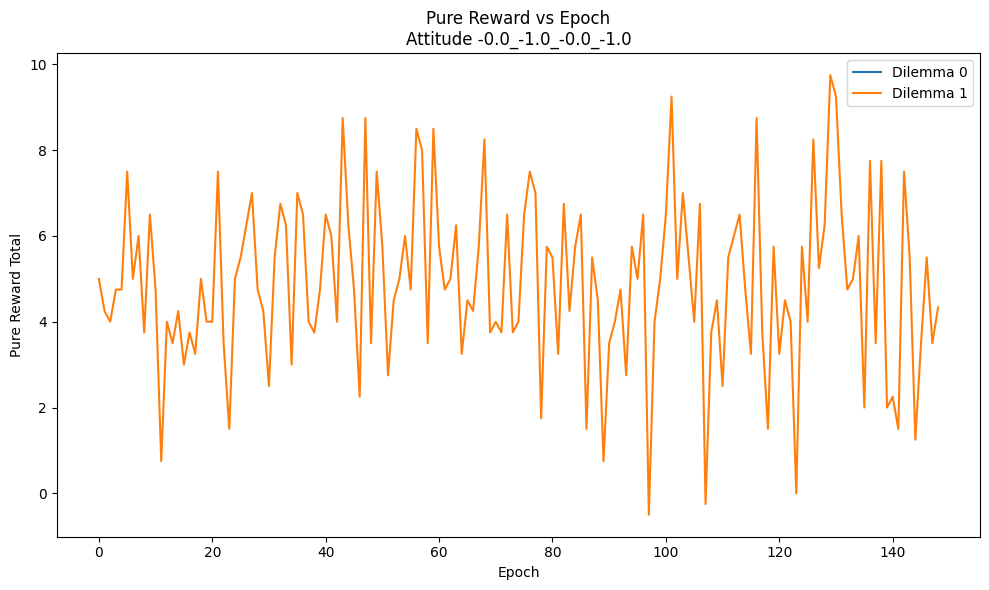

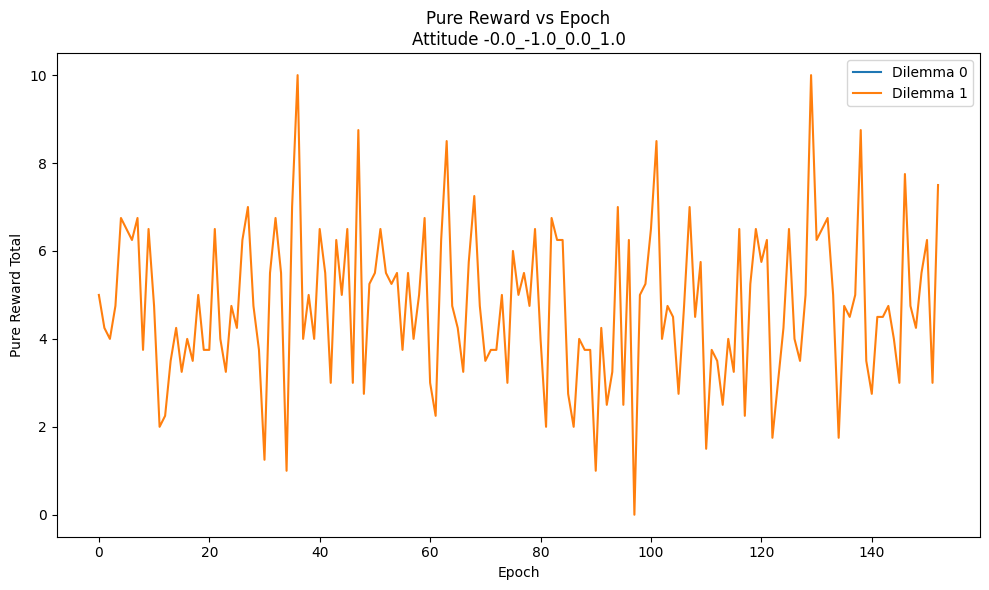

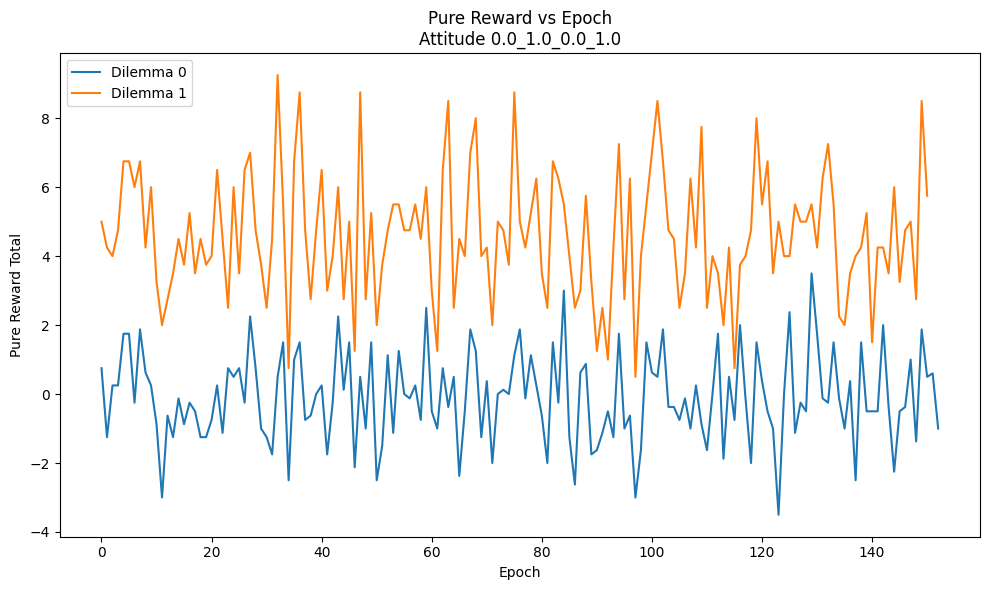

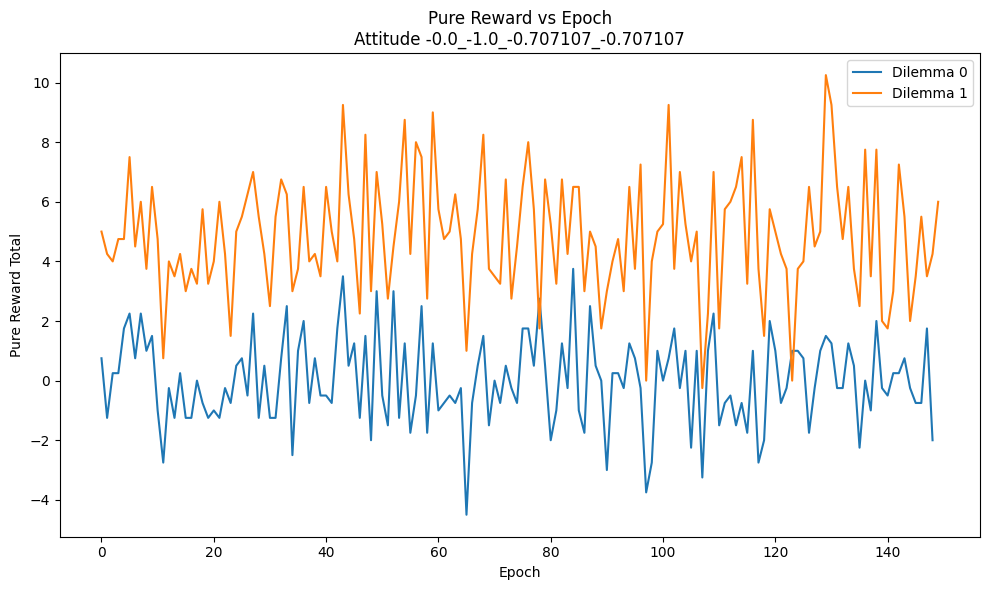

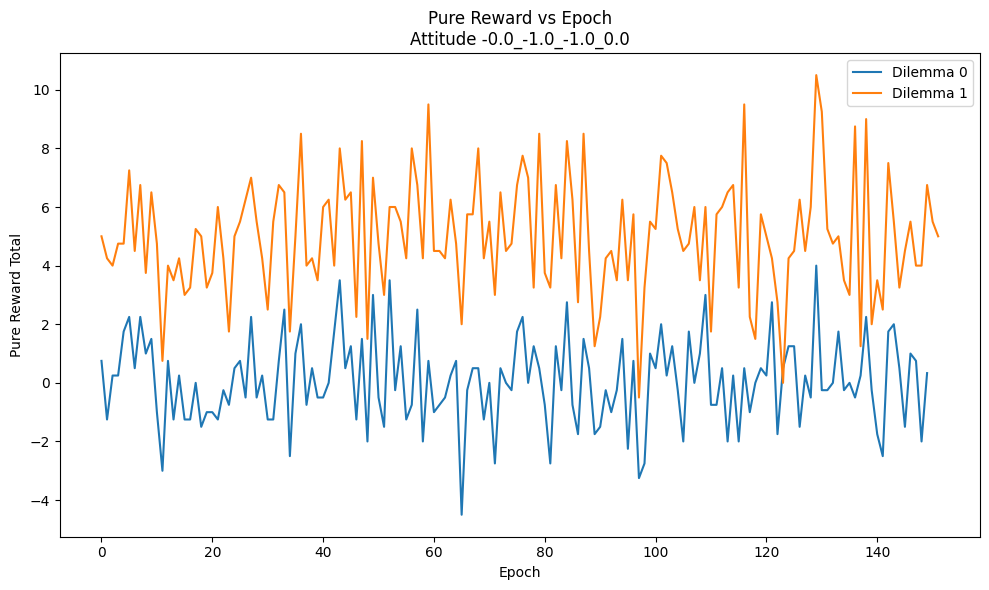

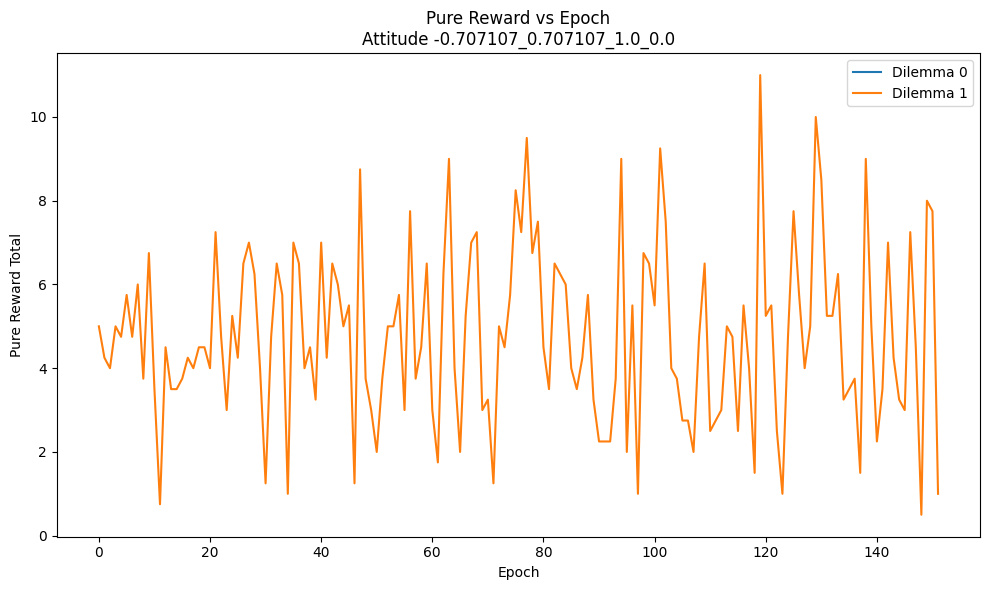

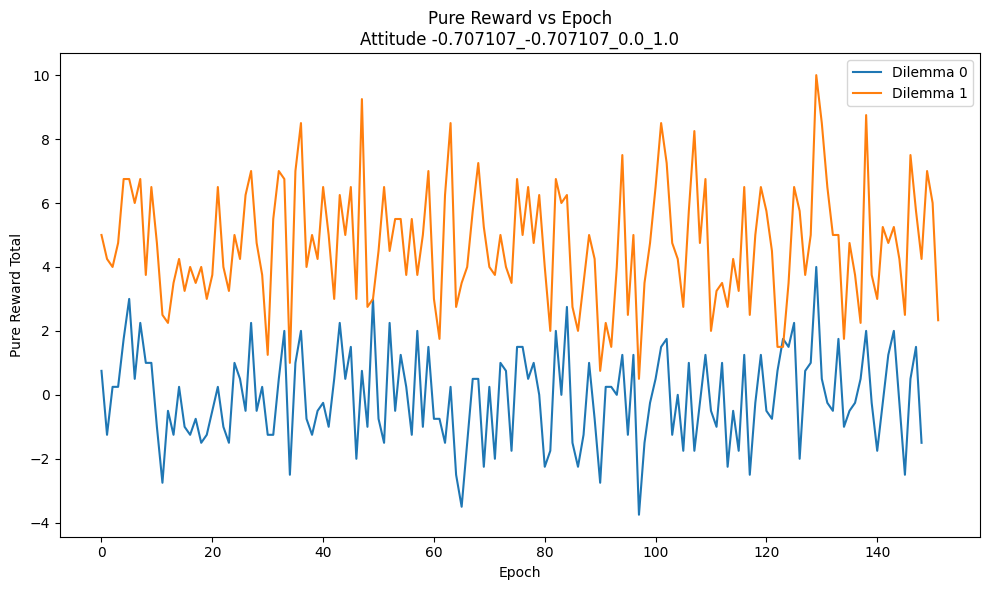

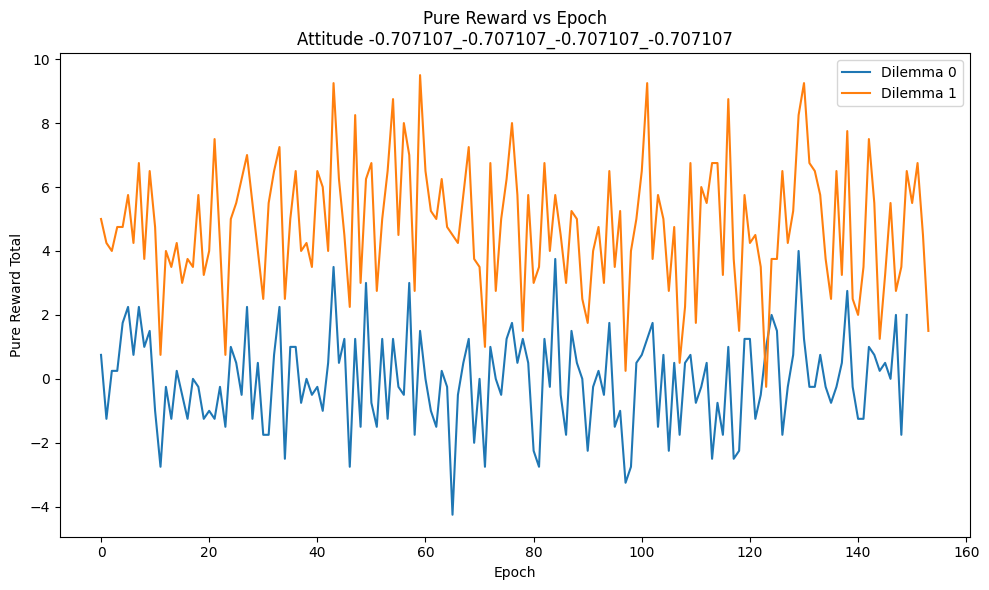

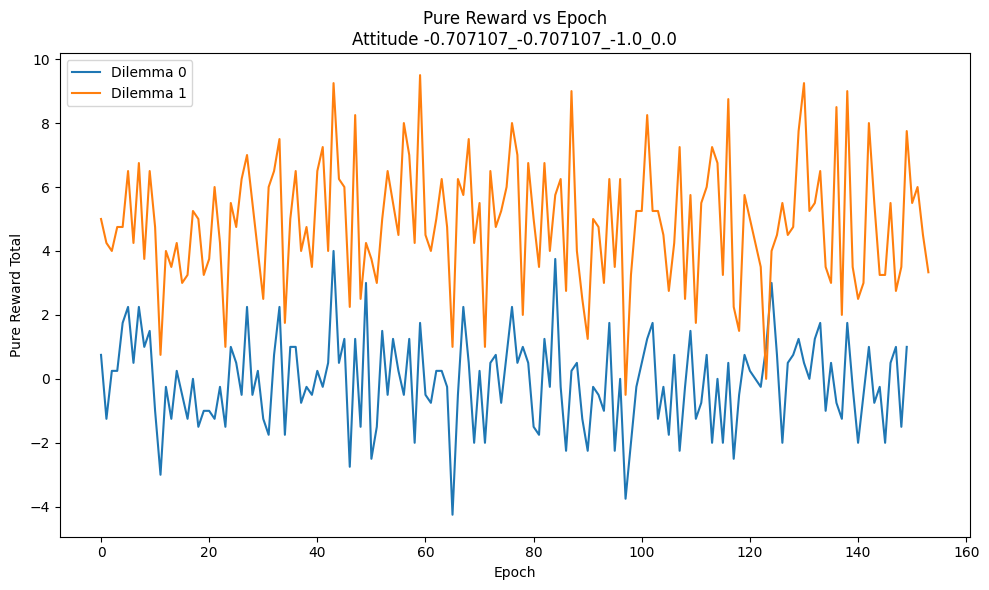

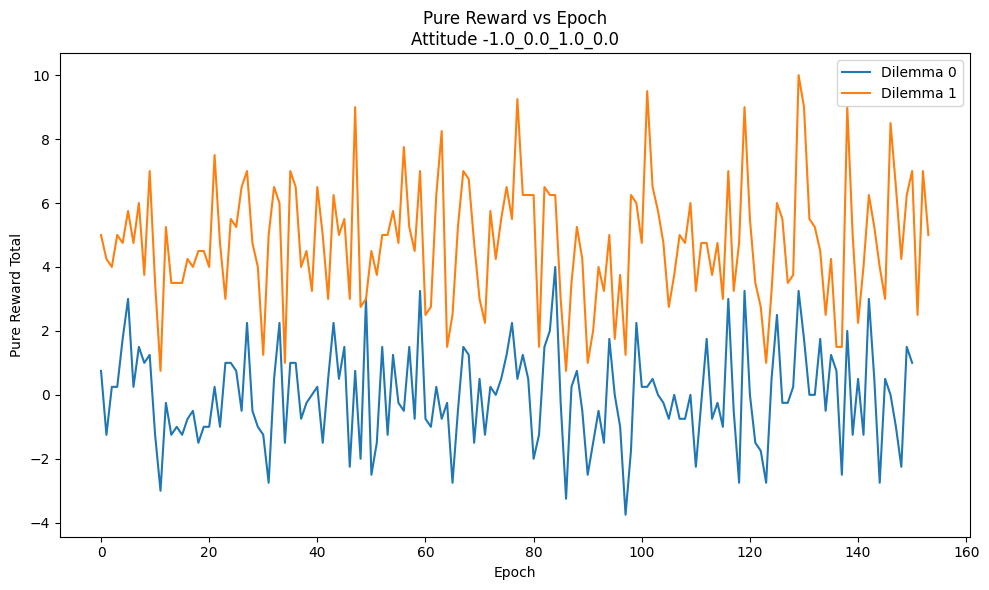

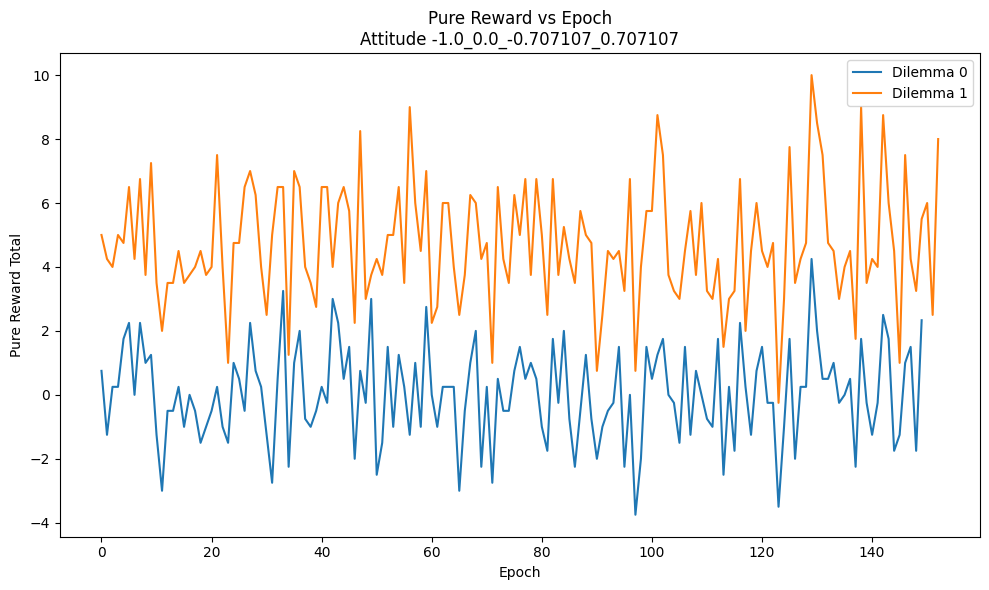

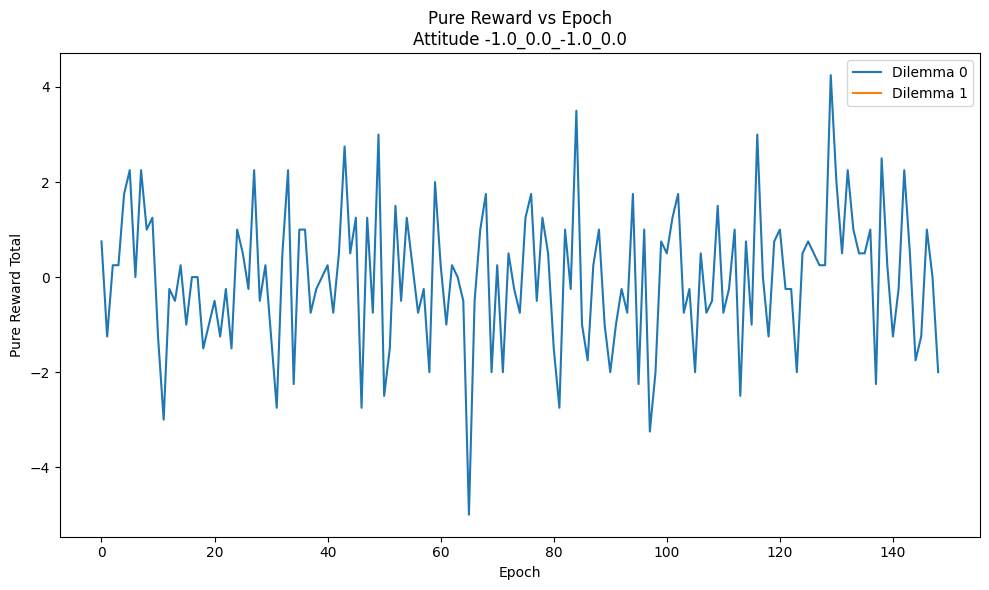

In [32]:
# Crear gráficas por combinación de coeficientes
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    # Crear la figura
    plt.figure(figsize=(10, 6))

    for dilemma_value in [0, 1]:
        filtered = subset[subset["dilemma"] == dilemma_value]

        # Agrupar por epoch y promediar la recompensa total
        grouped = filtered.groupby("epoch")["pure_reward_total"].mean().reset_index()
        label = f"Dilemma {dilemma_value}"
        plt.plot(grouped["epoch"], grouped["pure_reward_total"], label=label)

    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}")
    plt.xlabel("Epoch")
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()

    # Mostrar la gráfica (puedes cambiar a savefig si quieres guardarlas)
    plt.show()